In [1]:
import torch
import torch.nn as nn
from torchvision import datasets ,models,transforms
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.nn import Linear, ReLU, CrossEntropyLoss, Conv2d, MaxPool2d, Module
from torch.optim import Adam
import pandas as pd
import os
from os import listdir
from tqdm import tqdm_notebook as tqdm
from PIL import Image
from transformers import set_seed
import random

In [2]:
PATH_train="trainset"
TRAIN =Path(PATH_train)
batch_size = 2
#Learning Rate：學習率
LR = 0.0001
# Resize 調整圖片大小
transforms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

In [3]:
# 模型再現性 放在dataloader前面 #
def seed_all(seed):
  random.seed(seed)
  np.random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)  # 禁止hash随机化
  os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'  # 在cuda 10.2及以上的版本中，需要设置以下环境变量来保证cuda的结果可复现
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
##########################################

seed_all(42)
train_data = datasets.ImageFolder(TRAIN, transform=transforms)
train_size = int(0.7 * len(train_data))
valid_size = len(train_data) - train_size
train_data, valid_data = torch.utils.data.random_split(train_data, [train_size, valid_size])
# 分為訓練與驗證集，比例7:3，之後製作dataloader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)

In [4]:
# input_shape=(3,224,224)
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.cnn1 = nn.Conv2d(3, 16, kernel_size=3, stride=1) 
        self.relu1 = nn.ReLU(inplace=True) 
        # Max pool_1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        # Convolution_2
        self.cnn2 = nn.Conv2d(16,8, kernel_size=3, stride=1) 
        self.relu2 = nn.ReLU(inplace=True) 
        # Maxpool_2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        # Fullyconnected_1 
        self.fc = nn.Linear(8 * 54 * 54, 2)     
    #列出forward的路徑，將init列出的層代入
    def forward(self, x):
        out = self.cnn1(x) 
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1) 
        out = self.fc(out) 
        return out
    


In [5]:
def train(model,n_epochs,train_loader,valid_loader,optimizer,criterion):
    train_acc_his,valid_acc_his=[],[]
    train_losses_his,valid_losses_his=[],[]
    for epoch in range(1, n_epochs+1):
        # keep track of training and validation loss
        train_loss,valid_loss = 0.0,0.0
        train_losses,valid_losses=[],[]
        train_correct,val_correct,train_total,val_total=0,0,0,0
        train_pred,train_target=torch.zeros(1,1),torch.zeros(1,1) #(8,1)
        val_pred,val_target=torch.zeros(1,1),torch.zeros(1,1)
        count=0
        count2=0
        print('running epoch: {}'.format(epoch))
        ############################################
        
        
        
        
        # train the model
        model.train()
        model = model.cuda()
        for data, target in tqdm(train_loader):
            # move tensors to GPU if CUDA is available
            data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            #calculate accuracy
            pred = output.data.max(dim = 1, keepdim = True)[1]
            train_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            train_total += data.size(0)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_losses.append(loss.item()*data.size(0))
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            if count==0:
                train_pred=pred
                train_target=target.data.view_as(pred)
                count=count+1
            else:
                train_pred=torch.cat((train_pred,pred), 0)
                train_target=torch.cat((train_target,target.data.view_as(pred)), 0)
        train_pred=train_pred.cpu().view(-1).numpy().tolist()
        train_target=train_target.cpu().view(-1).numpy().tolist()
        ##################################################
        
        
        
        # validate the model
        model.eval()
        for data, target in tqdm(valid_loader):
            data, target = data.cuda(), target.cuda()
            output = model(data)
            # batch loss
            loss =criterion(output, target)
            #calculate accuracy
            pred = output.data.max(dim = 1, keepdim = True)[1]
            val_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            val_total += data.size(0)
            valid_losses.append(loss.item()*data.size(0))
            if count2==0:
                val_pred=pred
                val_target=target.data.view_as(pred)
                count2=count+1
            else:
                val_pred=torch.cat((val_pred,pred), 0)
                val_target=torch.cat((val_target,target.data.view_as(pred)), 0)
        val_pred=val_pred.cpu().view(-1).numpy().tolist()
        val_target=val_target.cpu().view(-1).numpy().tolist()
        
        # average losses
        train_loss=np.average(train_losses)
        valid_loss=np.average(valid_losses)
        
        # average accuracy
        train_acc= train_correct/train_total
        valid_acc= val_correct/val_total
        train_acc_his.append(train_acc)
        valid_acc_his.append(valid_acc)
        train_losses_his.append(train_loss)
        valid_losses_his.append(valid_loss)
        print('Training Loss: {:.6f}    Validation Loss: {:.6f}'.format(train_loss, valid_loss))
        print('Training Accuracy: {:.6f}    Validation Accuracy: {:.6f}'.format(train_acc, valid_acc))
    return train_acc_his,valid_acc_his,train_losses_his,valid_losses_his,model

In [6]:
model=CNN_Model()
n_epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = CrossEntropyLoss()
train_acc_his,valid_acc_his,train_losses_his,valid_losses_his,model1=train(model,n_epochs,train_loader,valid_loader,optimizer,criterion)

running epoch: 1


c:\Users\TMU\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/13 [00:00<?, ?it/s]

c:\Users\TMU\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/6 [00:00<?, ?it/s]

Training Loss: 1.368809    Validation Loss: 1.282596
Training Accuracy: 0.520000    Validation Accuracy: 0.454545
running epoch: 2


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Training Loss: 1.316388    Validation Loss: 1.270587
Training Accuracy: 0.600000    Validation Accuracy: 0.545455
running epoch: 3


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Training Loss: 1.282893    Validation Loss: 1.277392
Training Accuracy: 0.800000    Validation Accuracy: 0.363636
running epoch: 4


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Training Loss: 1.250821    Validation Loss: 1.292510
Training Accuracy: 0.720000    Validation Accuracy: 0.636364
running epoch: 5


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Training Loss: 1.182292    Validation Loss: 1.308343
Training Accuracy: 0.920000    Validation Accuracy: 0.181818
running epoch: 6


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Training Loss: 1.137788    Validation Loss: 1.353677
Training Accuracy: 0.880000    Validation Accuracy: 0.181818
running epoch: 7


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Training Loss: 1.051077    Validation Loss: 1.400135
Training Accuracy: 0.920000    Validation Accuracy: 0.181818
running epoch: 8


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Training Loss: 0.983207    Validation Loss: 1.447893
Training Accuracy: 0.800000    Validation Accuracy: 0.181818
running epoch: 9


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Training Loss: 0.909409    Validation Loss: 1.532060
Training Accuracy: 0.880000    Validation Accuracy: 0.363636
running epoch: 10


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Training Loss: 0.830510    Validation Loss: 1.626039
Training Accuracy: 0.960000    Validation Accuracy: 0.363636


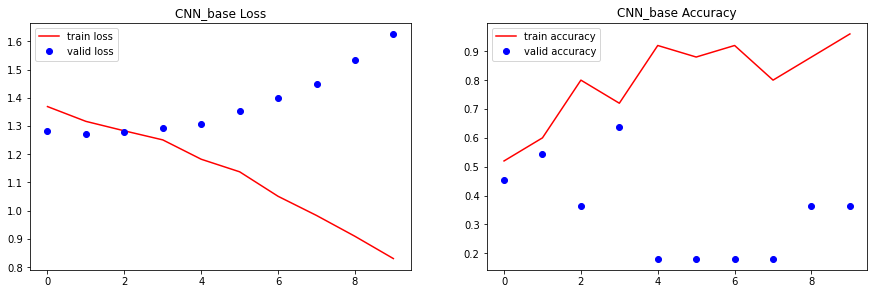

In [7]:
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.plot(train_losses_his, 'r', label = 'train loss')
plt.plot(valid_losses_his, 'bo', label = 'valid loss')
plt.title("CNN_base Loss")
plt.legend(loc='upper left')
plt.subplot(222)
plt.plot(train_acc_his, 'r', label = 'train accuracy')
plt.plot(valid_acc_his, 'bo', label = 'valid accuracy')
plt.title("CNN_base Accuracy")
plt.legend(loc='upper left')
plt.show()